# **1. International Education Calculator**

### James Capone

### June 2025

<center><img src="traveling student.jpg"/></center>

An unavoidable aspect of pursuing higher education is the financial commitment. This is often a major consideration when deciding which college program to pursue if able to attend. Tuition itself is only part of the financial picture, needing to account for other expenses that readily accompany the great opportunity. These expenses expand when considering ventures to foreign nations for collegiate programs. In order to aid in the selection process for students with finances in mind, a machine learning model was built here to estimate the complete total price of an international educational program. The total price target variable is composed of **tuition costs**, **rent**, **visa fees**, and **insurance** (health/student insurance) for the duration of the program. In order to receive an estimation, an individual would need to supply the **country**, the **city**, the **university**, the **program** (field of study), and the **level** (degree type) of the academic program in mind. Without overfitting the data, one will see that we were able to produce a prediction value within **$7,522.77 of the actual price**. Relative to the target’s data range, this deviation is small and could provide useful insights into which programs are financially likely. We will use a supervised learning approach to build our machine learning model, optimizing for the **root mean squared error (RMSE) performance metric**.

The data was acquired from kaggle where the numeric costs information was collected from various financial resources, seen [here](https://www.kaggle.com/datasets/adilshamim8/cost-of-international-education/data).

## 1.1. Common Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 1.2. Import the Data

In [11]:
# copy the raw, untouched data
raw_data = pd.read_csv('International_Education_Costs.csv')
df = raw_data.copy()

## 1.3. Glance at the Data

The data was relatively clean upon importation, free of null values or duplicates.

In [12]:
df.head()

,Country,City,University,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate
0,USA,Cambridge,Harvard University,Computer Science,Master,2.0,55400,83.5,2200,160,1500,1.00
1,UK,London,Imperial College London,Data Science,Master,1.0,41200,75.8,1800,485,800,0.79
2,Canada,Toronto,University of Toronto,Business Analytics,Master,2.0,38500,72.5,1600,235,900,1.35
3,Australia,Melbourne,University of Melbourne,Engineering,Master,2.0,42000,71.2,1400,450,650,1.52
4,Germany,Munich,Technical University of Munich,Mechanical Engineering,Master,2.0,500,70.5,1100,75,550,0.92


In [13]:
# overview of column data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            907 non-null    object 
 1   City               907 non-null    object 
 2   University         907 non-null    object 
 3   Program            907 non-null    object 
 4   Level              907 non-null    object 
 5   Duration_Years     907 non-null    float64
 6   Tuition_USD        907 non-null    int64  
 7   Living_Cost_Index  907 non-null    float64
 8   Rent_USD           907 non-null    int64  
 9   Visa_Fee_USD       907 non-null    int64  
 10  Insurance_USD      907 non-null    int64  
 11  Exchange_Rate      907 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 85.2+ KB


In [14]:
# check for null values
df.isnull().sum()

Country              0
City                 0
University           0
Program              0
Level                0
Duration_Years       0
Tuition_USD          0
Living_Cost_Index    0
Rent_USD             0
Visa_Fee_USD         0
Insurance_USD        0
Exchange_Rate        0
dtype: int64

In [16]:
# check for duplicate entries
df.duplicated().sum()

0

## 1.4. Label Creation

As stated, our goal with this project is to produce an estimation of the total cost of an inquiring international educational program. This will be accomplished using a statistical model that will produce this cost estimate using different categorical features. 

These predictor features include: **Country**, **City**, **University**, **Program**, and **Level**.

Since we are utilizing a supervised learning approach to construct our model, we will create a **Total_Cost** column as the training label. This label will be created using a custom transformer (`TotalCostConstructor`) that will add the Total_Cost column rounded to the nearest dollar using **Duration_Years**, **Tuition_USD**, **Rent_USD**, **Visa_Fee_USD**, and **Insurance_USD** columns.

As opposed to utilizing basic pandas to form the target label, creating a custom transformer can be beneficial in the future if we would want to retrain the model using new data. Training the model with new data could prevent model rot and improve results with changes in educational and economic pricings. For this application, we could also import the `TotalCostConstructor` transformer class to streamline the data preparation process.

Additionally, the custom class includes an added feature of creating an additional column outlining the annual cost of each program. Setting the `annual_cost` parameter to **True** will output the total cost (**Total_Cost**) and annual cost (**Annual_Cost**) of each program. Although the annual cost metric is not investigated in this analysis, future investigations may find use for this feature.

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

# column indexes for Duration_Years, Tuition_USD, Rent_USD, Visa_Fee_USD, and Insurance_USD

duration_years_ix = df.columns.get_loc('Duration_Years')
tuition_ix = df.columns.get_loc('Tuition_USD')
rent_ix = df.columns.get_loc('Rent_USD')
visa_fee_ix = df.columns.get_loc('Visa_Fee_USD')
insurance_ix = df.columns.get_loc('Insurance_USD')

# build Total_Cost constructor class

class TotalCostConstructor(BaseEstimator, TransformerMixin):
    def __init__(self, annual_cost = False):
        self.annual_cost = annual_cost

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X['Total_Cost'] = round(X.iloc[:, tuition_ix] + (X.iloc[:, duration_years_ix] * (X.iloc[:, rent_ix] * 12)) + (X.iloc[:, insurance_ix] * X.iloc[:, duration_years_ix]) + X.iloc[:, visa_fee_ix], 0)

        if self.annual_cost:
            X['Annual_Cost'] = round((X.iloc[:, tuition_ix] / X.iloc[:, duration_years_ix]) + (X.iloc[:, rent_ix] * 12) + X.iloc[:, insurance_ix] + (X.iloc[:, visa_fee_ix] / X.iloc[:, duration_years_ix]), 0)
            return X
            
        else:
            return X

In [18]:
# adding the Total_Cost column
label_creator = TotalCostConstructor(annual_cost = False)
df = label_creator.transform(df)

In [19]:
# ensure target label was created properly (last column)
df.head(1)

,Country,City,University,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate,Total_Cost
0,USA,Cambridge,Harvard University,Computer Science,Master,2.0,55400,83.5,2200,160,1500,1.0,111360.0


In [20]:
# general statistics on df features
df.describe()

,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate,Total_Cost
count,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000
mean,2.836825,16705.016538,64.437486,969.206174,211.396913,700.077178,623.000695,52218.111356
std,0.945449,16582.385275,14.056333,517.154752,143.435740,320.374875,3801.746134,37459.163755
min,1.000000,0.000000,27.800000,150.000000,40.000000,200.000000,0.150000,5700.000000
25%,2.000000,2850.000000,56.300000,545.000000,100.000000,450.000000,0.920000,22644.500000
50%,3.000000,7500.000000,67.500000,900.000000,160.000000,650.000000,1.350000,40020.000000
75%,4.000000,31100.000000,72.200000,1300.000000,240.000000,800.000000,7.150000,75600.000000
max,5.000000,62000.000000,122.400000,2500.000000,490.000000,1500.000000,42150.000000,199860.000000


## 1.5. Initial Findings

At first glance, all non-categorical numeric columns demonstrate an abnormal distribution. 

The Total_Cost target variable shows a right-skewed distribution. Additionally, 25% of international education programs exceed a total cost of \\$75,667.50, reaching a max total cost of \\$199,860. 

The Tuition_USD column’s distribution is severely right-skewed, possessing a large grouping of observations with tuition costs falling under $5,000 USD. 

Rent_USD also possesses a right-skewed distribution and appears to express two modal peaks.

Additionally, Duration_Years contains seven different year values within our dataset. Notably, 1, 1.5, 2.5, and 5 are scarce in quantity; all falling below 20 reports, and some showing less than 5 total accounts within the data. With this in mind, we will want to consider stratifying this value during data splitting.

Later on after splitting, we can see the Total_Cost label and Duration_Years variable express a correlational coefficient value of 0.43 in the training data. This moderate relationship supports the stratification decision, ensuring this variable’s distribution is preserved after splitting the data.


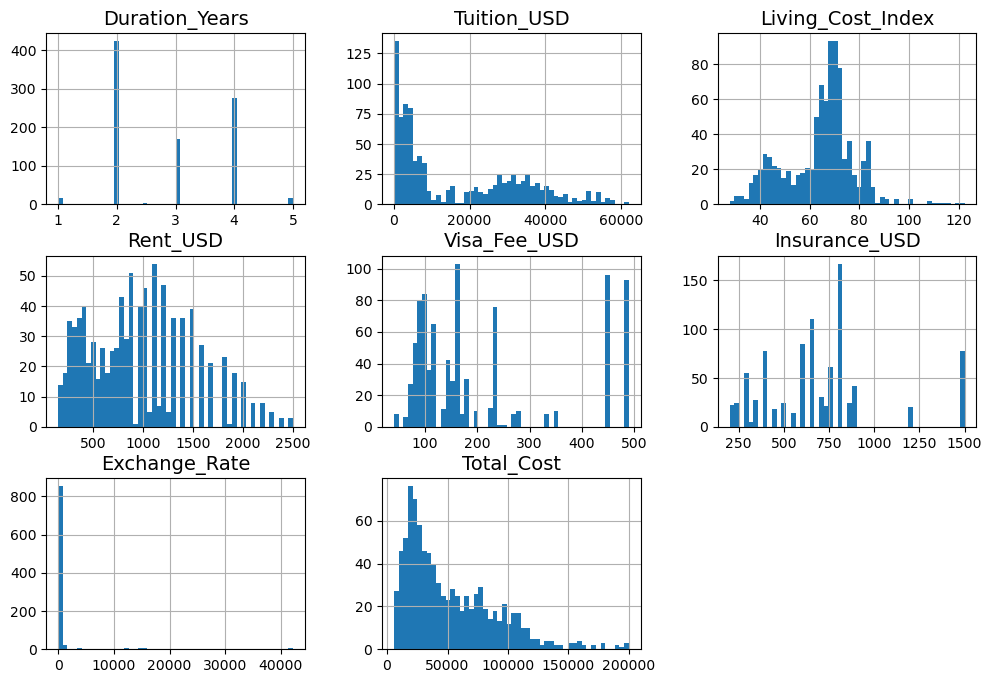

In [21]:
plt.rc('font', size = 14)
plt.rc('axes', labelsize = 14, titlesize = 14)
plt.rc('legend', fontsize = 14)
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)

df.hist(bins = 50, figsize = (12, 8))
plt.show()

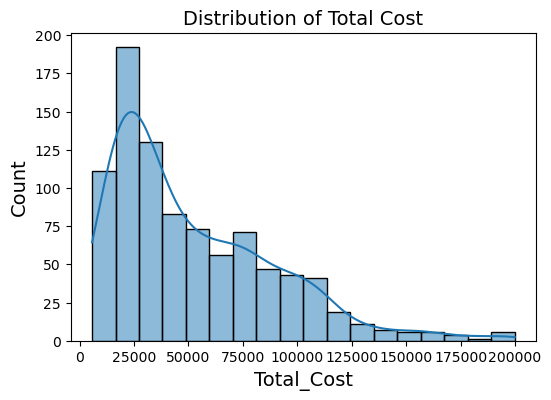

In [22]:
# closer examination of Total_Cost (label variable)

plt.figure(figsize = (6,4))
sns.histplot(df['Total_Cost'], kde = True)
plt.title('Distribution of Total Cost')
plt.show()

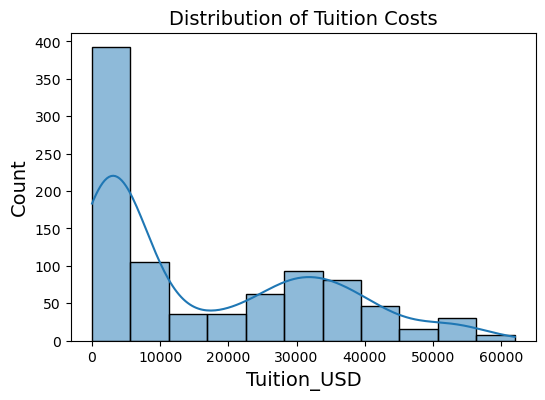

In [23]:
# closer examination of Tuition_USD

plt.figure(figsize = (6, 4))
sns.histplot(df['Tuition_USD'], kde = True)
plt.title('Distribution of Tuition Costs')
plt.show()

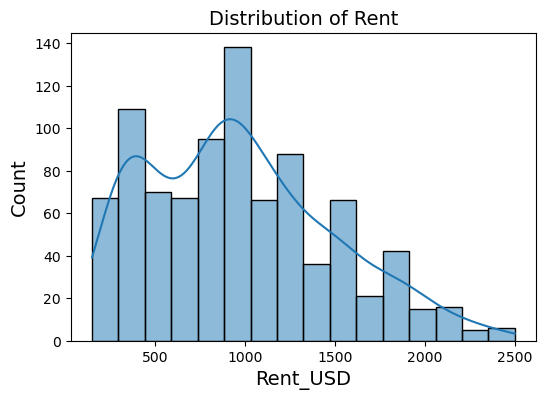

In [24]:
# closer examination of Rent_USD

plt.figure(figsize = (6, 4))
sns.histplot(df['Rent_USD'], kde = True)
plt.title('Distribution of Rent')
plt.show()

In [25]:
# viewing all values from Duration_Years column

df['Duration_Years'].value_counts().sort_index()

Duration_Years
1.0     16
1.5      1
2.0    423
2.5      3
3.0    171
4.0    276
5.0     17
Name: count, dtype: int64

# 2. Data Exploration

Before deep-diving into the data to gain a better understanding, we will split the dataset to avoid data snooping bias. Due to the relative size of the dataset (907 entries) we will allocate 20% of the data to a test set, storing it away until we are ready to test our machine learning model’s efficiency. The remaining 80% will further be divided to form a validation set, which will also allocate 20% of the remaining data after initial split. The validation set will be used to fine-tune the model, allowing us to analyze results on unseen data without exposing the model to the test set.

## 2.1. Data Splitting

As discussed previously, we will stratify the Duration_Years variable to ensure the test set contains a relatively similar distribution to the original data. However, when conducting a stratified split, it is required that each value within the stratified column must appear more than once. In the duration_years column, the “1.5” year value only appears once, thus limiting our use of stratification during data split. To combat this, we can gather additional data hoping to add to the “1.5” duration value, delete the entire data entry, or merge this with another observation to form a new value group (e.g., combining “1” and “1.5” to create a “less than 2 year” value group). Collecting more information would be ideal, however we will settle with removing this data entry.

In [26]:
# removing data entry where Duration_Years equals 1.5

df = df.drop(df[df['Duration_Years'] == 1.5].index)

In [27]:
# ensuring row was dropping properly

df['Duration_Years'].value_counts().sort_index()

Duration_Years
1.0     16
2.0    423
2.5      3
3.0    171
4.0    276
5.0     17
Name: count, dtype: int64

In [28]:
from sklearn.model_selection import train_test_split

# splitting the data
TEMP_train_set, test_set = train_test_split(df, stratify = df['Duration_Years'], test_size = 0.2, random_state = 42)

In [29]:
# creating a validation set
train_set, validation_set = train_test_split(TEMP_train_set, stratify = TEMP_train_set['Duration_Years'], test_size = 0.2, random_state = 42)


## 2.2. Stratified Distribution Check

We can check to see if stratifying the data during the data splitting process would be more optimal than a random split. The code blocks below accomplishes this unknown conclusion. 

We first create a new train and test set from the original dataset, omitting the `stratify` parameter to create a random split. We can then visualize the distribution of Duration_Years in the original data, stratified data, and random split data using a table. 

When comparing the *Stratified Split Error* to the *Random Split Error* in the visual, we can see the stratified grouping expresses less error compared to the random group. This concludes that the stratification of the Duration_Years variable during splitting produced a value distribution more similar to the original data than the random split.

In [30]:
# random split

rand_train_set, rand_test_set = train_test_split(df, test_size = 0.2, random_state = 42)

In [31]:
# stratified distribution check

def duration_years_proportion(data):
    return data['Duration_Years'].value_counts() / len(data)

duration_distribution = pd.DataFrame({
    'Raw Data': duration_years_proportion(df),
    'Stratified Split': duration_years_proportion(TEMP_train_set),
    'Random Split': duration_years_proportion(rand_train_set)
}).sort_index()

duration_distribution['Stratified Split Error'] = (duration_distribution['Stratified Split'] / duration_distribution['Raw Data']) - 1
duration_distribution['Random Split Error'] = (duration_distribution['Random Split'] / duration_distribution['Raw Data']) - 1

(duration_distribution * 100).round(2)

,Raw Data,Stratified Split,Random Split,Stratified Split Error,Random Split Error
Duration_Years,,,,,
1.0,1.77,1.80,1.93,1.67,9.50
2.0,46.69,46.69,46.27,-0.01,-0.90
2.5,0.33,0.28,0.41,-16.57,25.14
3.0,18.87,18.92,19.20,0.26,1.72
4.0,30.46,30.39,30.11,-0.25,-1.16
5.0,1.88,1.93,2.07,3.05,10.42


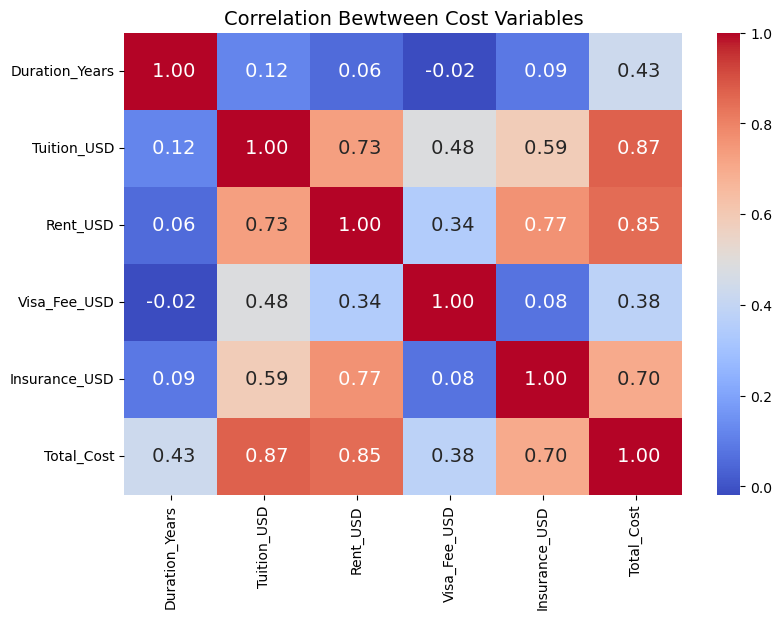

In [32]:
# correlation matrix

variable_corr = train_set[['Duration_Years', 'Tuition_USD', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Total_Cost']].corr()

plt.figure(figsize = (9, 6))
sns.heatmap(variable_corr, annot = True, fmt = ' .2f', cmap = 'coolwarm')
plt.title('Correlation Bewtween Cost Variables')
plt.show()

## 2.3. Data Exploration

For this section, we want to gain a better understanding of the data, looking for nuances, patterns, or potential obstacles for data preparation. *Figure 2.3.1.* shows the 10 countries with the highest and lowest program count. It is worth noting the steep dropoff from the 4th and 5th rank countries, revealing a difference of nearly 40 programs. Because this dataset is a sample of global programs, we can gather from this visual that the model will have more training instances from the USA, Australia, the UK, and Canada. This could lead to more accurate predictions for these countries because the model will have more data to learn from. Constrastingly, the model will have difficulty with predictions from the countries in the subplot below, such as Vietnam, Israel, or Hong Kong* to name a few with only one collegiate program. 

Similarly, *Figure 2.3.2.* visualizes the 10 most and least expensive countries based on the average total cost. The United States has the highest average total cost with roughly \\$120,000, contrasting Algeria with the lowest average total price of nearly \\$10,000.

Looking at *Figure 2.3.3.*, we can see the proportion of each degree type that exists in the training set. Based on the visual, we can gather that roughly 50% are Master’s degrees, ~35% Bachelor’s degrees, and ~17.5% Doctorate (PhD) degrees. Similar to countries, when an individual is attempting to estimate the total cost of an international PhD program, we may expect more error in the prediction compared to the other degree types due to the lacking quantity.

Additionally, if we wanted to know the price distributions for each degree type, we can look at *Figure 2.3.4.*. Based on this visual, we can see that outliers are present within the Master’s plot, skewing the distribution toward higher values. We will choose to leave these entries in the data due to the limited dataset size, however, noting the impact it has to the output for this inquiring degree type. Additionally, the PhD distribution appears to possess extreme higher cost programs, noting the median settles around \\$50,000, reaching a max of nearly \\$200,000.  

\* *Note: Although Hong Kong is commonly referred to as a region within China, it is technically a Special Administrative Region with a high degree of autonomy. Therefore, we will continue forward with Hong Kong referenced as its own country entity.*


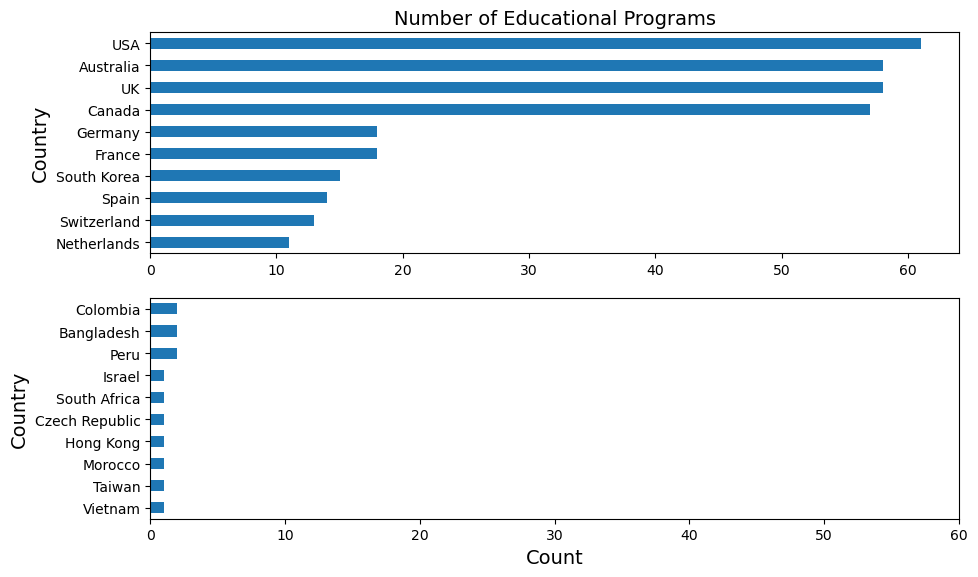

In [57]:
# Figure 2.3.1 - 10 highest and lowest program count by Country
plt.figure(figsize = (10, 6))

plt.subplot(2, 1, 1)
train_set['Country'].value_counts().head(10).iloc[::-1].plot(kind = 'barh')
plt.title('Number of Educational Programs')

plt.subplot(2, 1, 2)
train_set['Country'].value_counts(ascending = True).head(10).plot(kind = 'barh')
plt.xlabel('Count')
plt.xlim(0, 60)

plt.tight_layout()
plt.show()

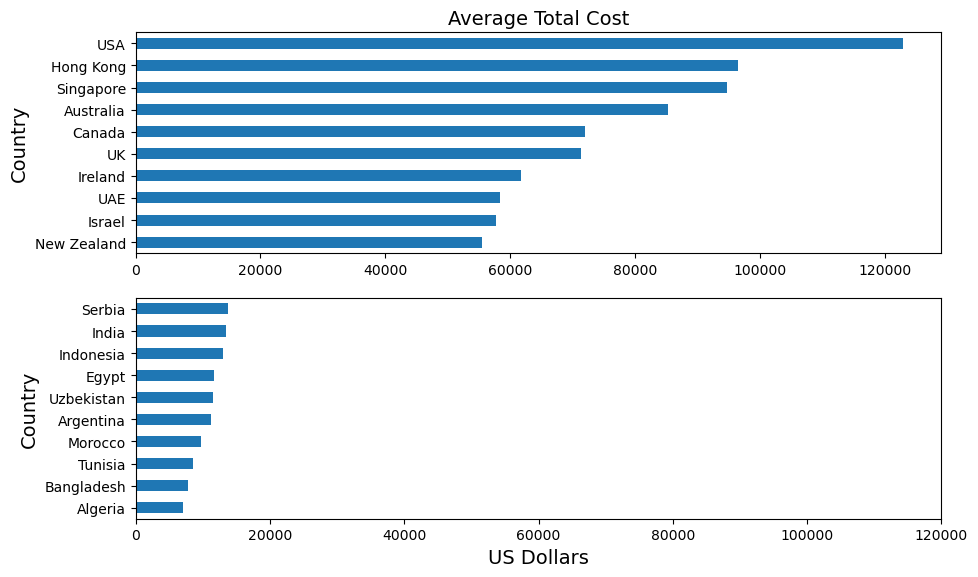

In [55]:
# Figure 2.3.2 - 10 most and least expensive countries on average

plt.figure(figsize = (10, 6))

plt.subplot(2, 1, 1)
train_set.groupby('Country')['Total_Cost'].mean().sort_values(ascending = False).head(10).round(2).iloc[::-1].plot(kind = 'barh')
plt.title('Average Total Cost')

plt.subplot(2, 1, 2)
train_set.groupby('Country')['Total_Cost'].mean().sort_values(ascending = True).round(2).head(10).plot(kind = 'barh')
plt.xlabel('US Dollars')
plt.xlim(0, 120000)

plt.tight_layout()
plt.show()

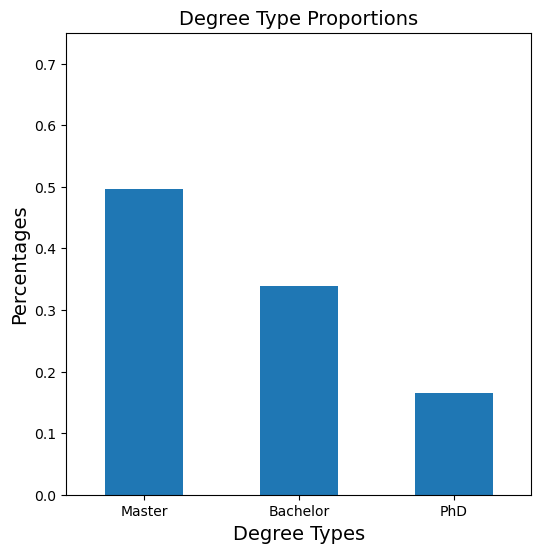

In [35]:
# Figure 2.3.3. - Degree Type Percentages
plt.figure(figsize = (6, 6))
(train_set['Level'].value_counts()/len(train_set)).plot(kind = 'bar')
plt.title('Degree Type Proportions')
plt.ylabel('Percentages')
plt.xlabel('Degree Types')
plt.xticks(rotation = 0)
plt.ylim(0, 0.75)
plt.show()

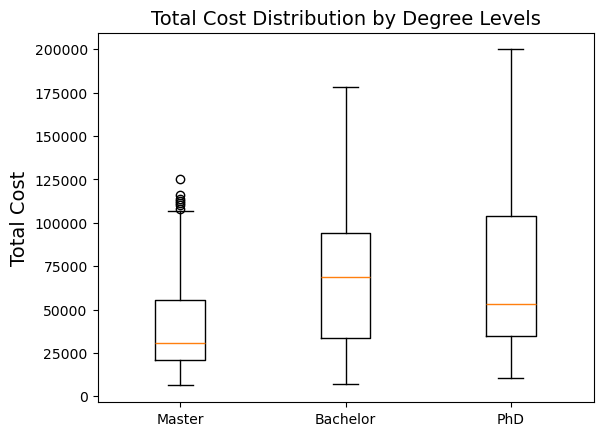

In [36]:
# Figure 2.3.4. - total cost distribution by degree type

degree_type = train_set['Level'].unique()

data = [train_set[train_set['Level'] == degree]['Total_Cost'] for degree in degree_type]

plt.boxplot(data, labels = degree_type)
plt.ylabel('Total Cost')
plt.title('Total Cost Distribution by Degree Levels')
plt.show()

# 3. Data Preparation

We will prepare the data for model insertion, packaging all data transformations into a ColumnTransformer from Sci-Kit Learn’s Compose library to streamline this preprocessing step. This will include transforming the categorical features (Country, City, University, Program, and Level) to numerical values. We will utilize One-Hot Encoding for Country, City, University, and Program variables, and incorporate an Ordinal Encoder for the Level variable to accomplish this goal. Additionally, each pipeline will include a SimpleImputer in future cases that new data may include missing values. For these cases, missing values will be replaced with the most frequent value or issued a “-1” placeholder. With this particular data and categorical feature types, there is no need to include a standardizer into the pipelines. The last step is performing `fit_transform` using our `preprocessing` column transformer onto the training features to produce the needed data format for model insertion.

## 3.1. Training Label Split

In [38]:
# separating features and target labels
train_features = train_set[['Country', 'City', 'University', 'Program', 'Level']]

train_labels = train_set['Total_Cost']

## 3.2. Pipeline Prep

In [39]:
# variable type assignment
categorical_columns = ['Country', 'City', 'University', 'Program']

ordinal_columns = ['Level']

## 3.2. Pipeline Assembly

In [40]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# categorical pipeline
categorical_pipeline = make_pipeline(SimpleImputer(strategy = 'most_frequent').set_output(transform = 'pandas'),
                                     OneHotEncoder(drop = 'first', handle_unknown = 'ignore'))

# ordinal pipeline
ordinal_pipeline = make_pipeline(SimpleImputer(strategy = 'most_frequent').set_output(transform = 'pandas'),
                                 OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1))

# assemble column transformer
preprocessing = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_columns),
    ('ord', ordinal_pipeline, ordinal_columns),
])

## 3.3. Transforming Dataset

In [41]:
features_prepared = preprocessing.fit_transform(train_features)

# 4. Model Selection

Based on the task of predicting the total price of an international education program, our performance metrics will be **RMSE** (Root Mean Squared Error) and **$R^{2}$** (Coefficient of Determination). RMSE measures the average error value from the predicted and actual values. $R^{2}$ will reveal how much variance is explained by the model (i.e., how much the model captures the overall trend in the data). We will also incorporate MAE (Mean Absolute Error) for interpreting the model results.

To start the model selection process, we will begin by selecting 3 models that may fit the characteristics of the data and the target goal. 

The first model will act as a baseline using **Linear Regression**. The data does not show much of a linear relationship, so we expect the target metrics to be unsatisfactory.

The second model will utilize a **Decision Tree Regressor**. This statistical model is ideal for nonlinear relationships. Additionally, decision trees are better suited to handle smaller datasets with categorical variables.

The last model uses **XGBoost** (Extreme Gradient Boost). This is a powerful statistical algorithm that can manage complex nonlinear relationships, outputs high accuracy, and incorporates regularization to reduce overfitting of the data.

## 4.1. Linear Regression

The Linear Regression model predicted the total cost with an average error of about $22,729.25, while explaining roughly 62% of the variance in the data.

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lin_reg = LinearRegression()

# Linear Regression RMSE score
rmse_score_lin_reg = -cross_val_score(lin_reg, features_prepared, train_labels,
                                    scoring = 'neg_root_mean_squared_error', cv = 3).mean()

# Linear Regression R2 score
r2_score_lin_reg = cross_val_score(lin_reg, features_prepared, train_labels,
                                    scoring = 'r2', cv = 3).mean()

print(f'Linear Regression RMSE Score: {round(rmse_score_lin_reg, 2)}')
print(f'Linear Regression R2 Score: {round(r2_score_lin_reg, 2)}')

Linear Regression RMSE Score: 22729.25
Linear Regression R2 Score: 0.62


## 4.2. Descision Tree Regressor

As expected, the decision tree performed better in both metrics compared to the simple linear regression. 

Overall, the Decision Tree Regressor model predicted the total cost with an average error of $16,803.22, explaining roughly 79% of the variance in the data.

In [43]:
from sklearn.tree import DecisionTreeRegressor

dec_tree = DecisionTreeRegressor(random_state = 42)

# Decision Tree Regressor RSME score
rsme_score_dec_tree = -cross_val_score(dec_tree, features_prepared, train_labels,
                                       scoring = 'neg_root_mean_squared_error', cv = 3).mean()

# Decision Tree Regressor R2 score
r2_score_dec_tree = cross_val_score(dec_tree, features_prepared, train_labels,
                                    scoring = 'r2', cv = 3).mean()

print(f'Decision Tree Regressor RMSE Score: {round(rsme_score_dec_tree, 2)}')
print(f'Decision Tree Regressor R2 Score: {round(r2_score_dec_tree, 2)}')

Decision Tree Regressor RMSE Score: 16803.22
Decision Tree Regressor R2 Score: 0.79


## 4.3.  XGBoost (Extreme Gradient Boost)

Once again, it was predicted the XGBoost Regressor would perform better when compared to the previous models, which it has.

The XGBoost Regressor model predicted the total cost with an average error of $10,988.08, explaining roughly 91% of variance in the data.

In [44]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor()

# XGBoost Regressor RMSE Score
rmse_score_xgb = -cross_val_score(xgb_reg, features_prepared, train_labels,
                                  scoring = 'neg_root_mean_squared_error', cv = 3).mean()

# XGBoost Regressor R2 Score
r2_score_xgb = cross_val_score(xgb_reg, features_prepared, train_labels,
                               scoring = 'r2', cv = 3).mean()

print(f'XGBoost Regressor RMSE Score: {round(rmse_score_xgb, 2)}')
print(f'XGBoost Regressor R2 Score: {round(r2_score_xgb, 2)}')


XGBoost Regressor RMSE Score: 10988.08
XGBoost Regressor R2 Score: 0.91


# 5. Fine-Tune Our Model

Based on the model results from the previous section, we will move forward with the pipeline assembly utilizing a **XGBoost Regression** model.

## 5.1. Selecting Best Training Parameters

We will be using a Grid Search from Scikit Learn’s Model Selection library to help narrow the parameter selection process to elicit the best results.

In [45]:
from sklearn.model_selection import GridSearchCV


# outling the parameter grid
param_grid = {'n_estimators': [100, 500, 1000],
              'learning_rate': [0.3, 0.1, 0.01],
              'max_depth': [3, 5, 7]
             }

# initialize grid search
grid_search = GridSearchCV(xgb_reg, param_grid,
                           scoring = ['neg_root_mean_squared_error', 'r2'], refit = 'neg_root_mean_squared_error',
                           return_train_score = True, cv = 3)
              

In [46]:
# fitting the grid search to the training data
grid_search.fit(features_prepared, train_labels)


# grid search best indicated parameters
print(f'The Best XGBRegessor Parameters: {grid_search.best_params_}')

# RMSE score
print(f'Tuned XGBRegressor RSME Score: {-round(grid_search.best_score_, 2)}')

The Best XGBRegessor Parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 500}
Tuned XGBRegressor RSME Score: 10653.3


## 5.2. Validation Set Preparation

In [47]:
# prepare validation set
val_labels = validation_set['Total_Cost']
val_features = validation_set[['Country', 'City', 'University', 'Program', 'Level']]

# preprocess validation set
val_features_prepared = preprocessing.transform(val_features)


## 5.3. Parameter Adjustments

Although GridSearchCV was initialized to help determine the best training parameters for the model, we instead used its results as a starting point for model tuning.

After using the suggested parameters, it can be seen later in *Figure 5.3.1.* titled “Grid Search Parameters”, that the validation RMSE flattens early into the training cycle, around the 75th estimator. The validation RMSE stopped improving at ~$10,156.38 RMSE, substantially lower than the base model earlier. Because we used early_stopping as a training parameter, we can conclude that the model would not improve further.

In the context of the overall dataset, the Total_Cost values range from \\$5,700 to \\$199,860, with a spanning dispersion of $194,160. Therefore, we can calculate the relative difference percentage between the training and validation RMSE at ~4.50%. This can be interpreted as; within our limited available range from the target variable (Total_Cost), the RMSE scores differ by roughly 4.50%.

This is an acceptable percentage and the visual does not suggest overfitting, however, further improvements can be made.

In [48]:
# assemblying a draft XGBRegressor model
draft_model = XGBRegressor(n_estimators = 500, max_depth = 5, learning_rate = 0.3, 
                           eval_metric = 'rmse', 
                           early_stopping_rounds = 50)


# test model using validation set
draft_model.fit(features_prepared, train_labels,
                eval_set = [(features_prepared, train_labels), (val_features_prepared, val_labels)],
               verbose = 100)

[0]	validation_0-rmse:28655.97870	validation_1-rmse:28891.58008
[100]	validation_0-rmse:5152.77049	validation_1-rmse:10845.69647
[200]	validation_0-rmse:3246.93387	validation_1-rmse:10307.83563
[300]	validation_0-rmse:2282.44902	validation_1-rmse:10209.94147
[400]	validation_0-rmse:1702.06129	validation_1-rmse:10163.36639
[475]	validation_0-rmse:1424.09934	validation_1-rmse:10156.37786


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

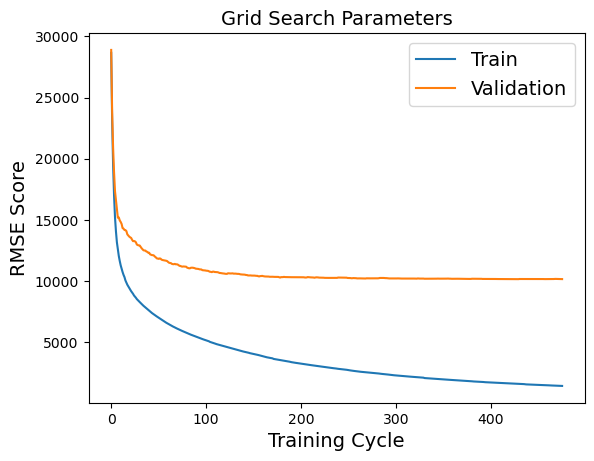

In [49]:
# Figure 5.3.1. - grid search parameters
eval_result = draft_model.evals_result()

train_rmse = eval_result['validation_0']['rmse']
val_rmse = eval_result['validation_1']['rmse']

plt.plot(train_rmse, label = 'Train')
plt.plot(val_rmse, label = 'Validation')
plt.title('Grid Search Parameters')
plt.xlabel('Training Cycle')
plt.ylabel('RMSE Score')
plt.legend()
plt.show()

## 5.4. Final Model Assembly

The final model’s parameters can be seen below, reducing the learning rate and max depth, while increasing the number of estimators (i.e., trees). A reg_alpha value was also supplied to aid in regularization, thus reducing the chances of overfitting the training data. 

The “Optimized Parameters” visual (*Figure 5.4.1.*) displays the RMSE performance of the final model. It shares a similar shape with the Grid Search Parameters, however expressing a smaller gap between the Train and Validation performance. Specifically, the relative difference percentage for the Optimized Parameters in relation to the overall target variable data range can be calculated as **~3.40%**. Once again, this is an acceptable range and an improvement from the previous model. 

Like before, the final model incorporated early_stopping so we can conclude the model had reached its optimal improvement level. The validation RMSE for the final model was measured at **~\\$10,178.00**, slightly worse than the grid search parameters at ~$10,156.38 RMSE. However, with a minimal difference in RMSE and a better relative difference percentage, we will proceed with evaluating the test set with the latter parameters.

In [50]:
# assemblying final XGBRegressor model
final_model = XGBRegressor(n_estimators = 2000, max_depth = 4, learning_rate = 0.05, 
                           eval_metric = 'rmse', reg_alpha = 5,
                           early_stopping_rounds = 50)


# test model using validation set
final_model.fit(features_prepared, train_labels,
                eval_set = [(features_prepared, train_labels), (val_features_prepared, val_labels)],
                verbose = 500)

[0]	validation_0-rmse:35894.22035	validation_1-rmse:35384.45790
[100]	validation_0-rmse:12074.28366	validation_1-rmse:15176.66326
[200]	validation_0-rmse:9956.00608	validation_1-rmse:13637.01827
[300]	validation_0-rmse:8798.45929	validation_1-rmse:12612.85007
[400]	validation_0-rmse:7931.52380	validation_1-rmse:11974.79798
[500]	validation_0-rmse:7258.81664	validation_1-rmse:11526.26761
[600]	validation_0-rmse:6720.13139	validation_1-rmse:11196.04675
[700]	validation_0-rmse:6266.68732	validation_1-rmse:10972.08032
[800]	validation_0-rmse:5872.25707	validation_1-rmse:10810.86346
[900]	validation_0-rmse:5516.75469	validation_1-rmse:10659.34317
[1000]	validation_0-rmse:5208.26603	validation_1-rmse:10573.65241
[1100]	validation_0-rmse:4922.33463	validation_1-rmse:10473.12597
[1200]	validation_0-rmse:4669.19033	validation_1-rmse:10391.15923
[1300]	validation_0-rmse:4446.40149	validation_1-rmse:10322.26918
[1400]	validation_0-rmse:4234.64707	validation_1-rmse:10271.64963
[1500]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=None, num_parallel_tree=None, ...)

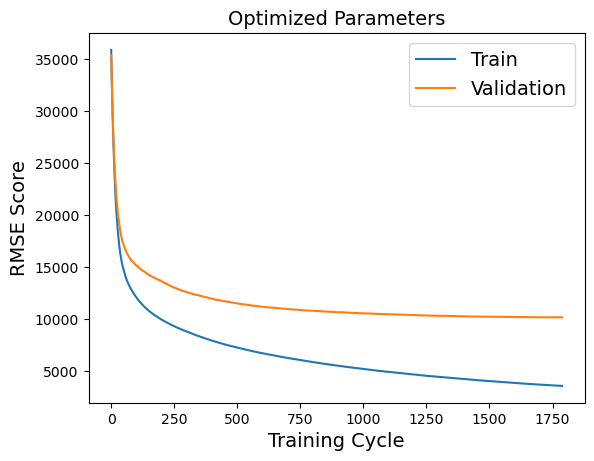

In [51]:
# Figure 5.4.1. - visualize for overfitting
eval_result = final_model.evals_result()

train_rmse = eval_result['validation_0']['rmse']
val_rmse = eval_result['validation_1']['rmse']

plt.plot(train_rmse, label = 'Train')
plt.plot(val_rmse, label = 'Validation')
plt.title('Optimized Parameters')
plt.xlabel('Training Cycle')
plt.ylabel('RMSE Score')
plt.legend()
plt.show()

# 6. Model Evaluation on Test Set

The final model produced an **RMSE score of \\$10,264.61** on the test data. In the context of the target label’s value range (\\$5,700-$199,860) in the dataset, the relative difference between the training RMSE and test RMSE is roughly **3.44%**. Based on a small relative difference percentage for the test data, this suggests the model would generalize well to new data due to similar performance.

We can incorporate the Mean Absolute Error evaluation metric to determine the average absolute prediction error the model makes. The final model produced an **MAE of \\$7,522.77**, meaning that on average, the model predictions is \\$7,522.77 of the actual price.

When collecting the **$R^{2}$ score** (as we did with the base models), the final model was able to account for **93%** of total variance within the data. This desirable value indicates the final model was able to fit successfully to the test data, increasing the reliability of the estimation output.

## 6.1. Test Set Preparation

In [52]:
# prepare test set
test_labels = test_set['Total_Cost']
test_features = test_set[['Country', 'City', 'University', 'Program', 'Level']]

# preprocess test set
test_features_prepared = preprocessing.transform(test_features)

## 6.2. Final Model Predictions

In [53]:
# model predictions
predictions = final_model.predict(test_features_prepared)

# final model RMSE score
final_rmse = mean_squared_error(test_labels, predictions, squared = False)

# final model Mean Absolute Error (MAE) score
final_mae = mean_absolute_error(test_labels, predictions)

# final model R2 score
final_r2 = r2_score(test_labels, predictions)


print(f'Final Model RMSE Score on Test Set: {round(final_rmse, 2)}')
print(f'Final Model MAE Score on Test Set: {round(final_mae, 2)}')
print(f'Final Model R2 Score on Test Set: {round(final_r2, 2)}')

Final Model RMSE Score on Test Set: 10264.61
Final Model MAE Score on Test Set: 7522.77
Final Model R2 Score on Test Set: 0.93


# 7. Results

In the context of our research question, our final model was able to achieve a root mean squared error (RMSE) of **\\$10,264.61** on the test data. The relative difference between the training RMSE and test RMSE was calculated at roughly **3.44%**, meaning the model performed generally similar to the test set in relation to the total value range (\\$5,700-\\$199,860) of the target label. The root mean squared error metric penalizes larger prediction errors more harshly, therefore leading to the notion that the model’s predictions were generally close to the actual program’s cost with extreme deviations accounted for.

Similarly, we can look toward the model’s absolute prediction error (MAE) to determine, on average, how much the predicted cost deviates from the actual price. The model produced an MAE value of **\\$7,522.77**, meaning that the model’s prediction is roughly within $7,522.77 of the true cost of the abroad higher education program.

These metrics are supported with the model’s $R^{2}$ value of **0.93**, illustrating the model was able to capture 93% of the variance within new data (i.e., test set). This would prove the model is capturing the underlying pattern present within the data, thus leading to better cost predictions.

Additionally, we can look at the scatterplot below that plots the predicted costs against the actual costs. As hoped, the visual illustrates a strong positive correlation with a correlation coefficient of 0.97. Because the plotted points are clustered closely to the linear line, it would further suggest good model performance and minimal error.


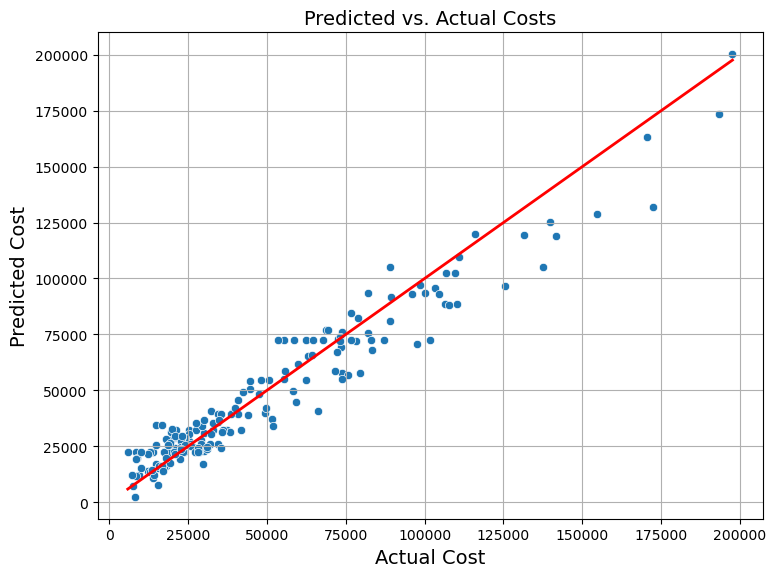

Correlation Coefficient: 0.97


In [54]:
from scipy import stats

# scatterplot of predicted values vs. actual values
plt.figure(figsize= (8,6))
sns.scatterplot(x = test_labels, y = predictions)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], color='red', lw=2)
plt.xlabel('Actual Cost')
plt.ylabel('Predicted Cost')
plt.title('Predicted vs. Actual Costs')
plt.grid(True)
plt.tight_layout()
plt.show()

# correlation between predicted values vs. actual values
correlation, p_value = stats.pearsonr(test_labels, predictions)

print(f'Correlation Coefficient: {round(correlation, 2)}')

# 8. Conclusion

When seeking to determine the monetary cost of international higher education programs, we built a model that could provide a reasonable estimate of the total price of an inquiring degree program using the country, city, university, program (field of study), and level (degree type). The model can be a useful tool for the decision-making process of an international program selection, most notably the financial aspect. Our model’s total price prediction not only includes the tuition expenses, but also visa costs, insurance, and rent for the entire duration of the collegiate program. **When using the model, an individual can expect a predicted total cost to be within $7,522.77 of the actual price**. Although not an exact prediction, this measurement could be used to give students a quick estimate with their predetermined price range in mind. Additionally, the model does not account for other expenses that may be required for program completion, such as food costs, daily transportation, misfortunes, or other required costs. The Living_Cost_Index variable does account for some of these costs, however, I did not form a valid solution to quantify the index ranking structure (i.e., convert rankings into dollars).

Overall, I am satisfied with the model assembly and results. A model was produced that supplies a prediction price similar to the actual price with a high level of certainty without overfitting the data. With a lack of similar apps or websites, this model could save individuals time, not having to research tedious expenses aside from tuition such as insurance or visa costs for a designated country. To improve model predictions, more data can be collected, especially in countries that were under-represented in this sample dataset. Additionally, because the custom transformer includes an option to produce an annual cost variable, this model could be used by current collegiate students looking to transfer universities. We may also look to predict the cost based on the degree-type in mind. This extraction may provide more accurate prediction costs if the model is trained on data solely of that degree type since higher degrees such as doctorates are typically more financially demanding. Lastly, future iterations could also look to expand the components of the total cost target variable to include other financial costs mentioned previously. This expansion would further provide individuals with the convenience of planning their academic future, painting a detailed financial portrait.


## 8.1. Save Final Model

In [ ]:
import joblib

# saving the model
joblib.dump(final_model, 'international_education_calculator.pkl')